# Iowa Liquor Sales Analysis Data Cleaning and Prepping

# THE SOURCE
Data on Iowa's alcohol sales from January 1, 2012, through April 1, 2023
These monthly updated Iowa liquor sale databases were obtained from the Alcoholic Beverages Division of the Iowa Department of Commerce.

This dataset includes information on the spirits purchased by Iowa Class "E" liquor licence holders between January 1, 2012, and the present, broken down by product and date of purchase. The dataset can be used to examine specific product sales of spirits at the retail level in Iowa as a whole.Grocery, liquor, convenience, etc. stores with a Class E liquor licence are able to sell alcohol in its original, unopened packaging for consumption off-site. 



## Setup & Imports

In [1]:
# Common imports
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import os

# Plotting imports and settings
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (13,8)

# Metrics and useful imports
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold


In [2]:
# Make output stable
np.random.seed(0)

## Load

In [3]:
%%time
IowaSales = pd.read_csv("Iowa_Liquor_Sales2.csv", low_memory=False)
IowaSales.shape

CPU times: total: 1min 46s
Wall time: 5min 54s


(26160915, 24)

This dataset comprised over 26 million rows and 24 column of data.

## Explore

In [4]:
size = IowaSales.shape[0]
if(pd.options.display.max_info_rows <= size):
  pd.options.display.max_info_rows = size + 1


## Checking and removing null/missing values 

In [5]:
IowaSales.isna().sum()

Invoice/Item Number            0
Date                           0
Store Number                   0
Store Name                     0
Address                    82627
City                       82626
Zip Code                   82693
Store Location           2495742
County Number            2028072
County                    159429
Category                   16974
Category Name              25040
Vendor Number                  9
Vendor Name                    7
Item Number                    0
Item Description               0
Pack                           0
Bottle Volume (ml)             0
State Bottle Cost             10
State Bottle Retail           10
Bottles Sold                   0
Sale (Dollars)                10
Volume Sold (Liters)           0
Volume Sold (Gallons)          0
dtype: int64

### Attribute Information
0. **`Invoice/Item Number`**    
1. **`Date`**                  
2. **`Store Number`**           
3. **`Store Name`**:            
4. **`Address`**: missing 82627 values,               
5. **`City`**: missing 82626 values,                    
6. **`Zip Code`**: missing 82693 values,                
7. **`Store Location`**: missing 2495742 values, split to longtidute and latitude         
8. **`County Number`**: missing 2028072 values
9. **`County`**: missing 159429 values, 
10. **`Category`**: missing 16974 values
11. **`Category Name`**: missing 25040 values
12. **`Vendor Number`**: missing 9 values
13. **`Vendor Name`**: missing 7 values, 
14. **`Item Number`**           
15. **`Item Description`**:       
16. **`Pack`**                
17. **`Bottle Volume (ml)`**     
18. **`State Bottle Cost`**: missing 10 values
19. **`State Bottle Retail`**: missing 10 values    
20. **`Bottles Sold`**            
21. **`Sale (Dollars)`**: missing 10 values        
22. **`Volume Sold (Liters)`**   
23. **`Volume Sold (Gallons)`** 

In [6]:
IowaSales_Copy = IowaSales.copy()
IowaSales_Copy_NoSaleNa = IowaSales_Copy.dropna(subset=['Sale (Dollars)'])
IowaSales_Copy_NoSaleNa.isna().sum()

# Try to locate some mapping for filling in some N/A data
store_locs_withna = IowaSales_Copy[['Store Number', 'Store Location', 'Zip Code', 'City', 'County Number']]
store_locs = store_locs_withna.dropna()
store_locs_unique_idx =  store_locs['Store Number'].duplicated()
store_locs_unique_idx = (store_locs_unique_idx == False)
store_locs_unique = store_locs[store_locs_unique_idx]
store_locs_unique.head()

,Store Number,Store Location,Zip Code,City,County Number
0,2569,POINT (-91.630677 42.027805),52402,CEDAR RAPIDS,57.0
1,4167,POINT (-90.668138 42.504959),52001,DUBUQUE,31.0
2,4147,POINT (-92.474689 42.539076),50613,CEDAR FALLS,7.0
3,2556,POINT (-94.829962 43.402096),51334,ESTHERVILLE,32.0
5,3995,POINT (-92.430437 42.512768),50613,CEDAR FALLS,7.0


We are looking for a mapping to fill in the 'Store Location', 'Zip Code', 'City', and 'County Number' columns of the 'IowaSales_Copy_raw' DataFrame, which include missing data (N/G values). In order to accomplish this, a new DataFrame called "store_locs_withna" is created, including the pertinent columns, and any rows with missing values are dropped. Additionally, an exclusive index based on the "Store Number" column is created. The first five rows of the resulting DataFrame, which contain the unique locations of each store without any missing values, are then displayed. These unique rows are chosen based on this index. Using the 'Store Number' column as a key, this data can be utilised to complete the blanks in the original DataFrame.

In [7]:
store_locs_unique_ts = store_locs_unique.set_index('Store Number')
store_locs_unique_ts

,Store Location,Zip Code,City,County Number
Store Number,,,,
2569,POINT (-91.630677 42.027805),52402,CEDAR RAPIDS,57.0
4167,POINT (-90.668138 42.504959),52001,DUBUQUE,31.0
4147,POINT (-92.474689 42.539076),50613,CEDAR FALLS,7.0
2556,POINT (-94.829962 43.402096),51334,ESTHERVILLE,32.0
3995,POINT (-92.430437 42.512768),50613,CEDAR FALLS,7.0
...,...,...,...,...
9934,POINT (-90.455001 41.571059),52722,BETTENDORF,82.0
5372,POINT (-95.477367 43.184821),51346,HARTLEY,71.0
5370,POINT (-91.666012 42.745695),50606,ARLINGTON,33.0


In [8]:
# Try to map using existing mapping in data
IowaSales_Copy.loc[IowaSales_Copy['Store Location'].isna(),'Store Location'] = IowaSales_Copy['Store Number'].map(lambda x: store_locs_unique_ts.at[x, 'Store Location'] if x in store_locs_unique_ts.index else np.NaN)
IowaSales_Copy.loc[IowaSales_Copy['Zip Code'].isna(),'Zip Code'] = IowaSales_Copy['Store Number'].map(lambda x: store_locs_unique_ts.at[x, 'Zip Code'] if x in store_locs_unique_ts.index else np.NaN)
IowaSales_Copy.loc[IowaSales_Copy['City'].isna(),'City'] = IowaSales_Copy['Store Number'].map(lambda x: store_locs_unique_ts.at[x, 'City'] if x in store_locs_unique_ts.index else np.NaN)
IowaSales_Copy.loc[IowaSales_Copy['County Number'].isna(),'County Number'] = IowaSales_Copy['Store Number'].map(lambda x: store_locs_unique_ts.at[x, 'County Number'] if x in store_locs_unique_ts.index else np.NaN)
IowaSales_Copy = IowaSales_Copy.dropna(subset=['Sale (Dollars)'])

Using existing mappings from the "store_locs_unique_ts" DataFrame, we are attempting to fill in missing values in the "Store Location," "Zip Code," "City," and "County Number" columns of the "IowaSales_Copy_raw" DataFrame. This is accomplished by applying a lambda function to each missing value in the relevant columns, mapping each "Store Number" to, if available, its corresponding value in the "store_locs_unique_ts" DataFrame, or else assigning a missing value. To make sure the data is clear and suitable for analysis, the algorithm removes any rows with missing data in the "Sale (Dollars)" column.



In [9]:
# CLean up to re-categorize the Categories
IowaSales_Copy['Category Name'] = IowaSales_Copy['Category Name'].apply(lambda x: x.upper() if isinstance(x, str) else None)
IowaSales_Copy['Category Name']= IowaSales_Copy['Category Name'].apply(
    lambda x: None if x is None else 
    'WHISKY' if 'WHISKIES' in x else
    'WHISKY' if 'WHISKY' in x else
    'VODKA' if 'VODKA' in x else
    'RUM' if 'RUM' in x else
    'BEER' if 'BEER' in x else    
    'TEQUILA' if 'TEQUILA' in x else    
    'COCKTAIL' if 'COCKTAIL' in x else    
    'BRANDIES' if 'BRANDIES' in x else    
    'SCHNAPPS' if 'SCHNAPPS' in x else    
    'SCOTCH' if 'SCOTCH' in x else    
    'CORDIALS & LIQUEURS' if 'CORDIAL' in x else    
    'CORDIALS & LIQUEURS' if 'LIQUEUR' in x else    
    'CORDIALS & LIQUEURS' if 'TRIPLE SEC' in x else 
    'CORDIALS & LIQUEURS' if 'AMERICAN ALCOHOL' in x else
    'AMARETTO' if 'AMARETTO' in x else
    'SPIRIT SPECIALTY' if 'DISTILLED SPIRIT' in x else
    'SPIRIT SPECIALTY' if 'SPIRIT' in x else
    'SPIRIT SPECIALTY' if 'SPECIALTY' in x else
    'SPIRIT SPECIALTY' if 'CREME' in x else
    'SPIRIT SPECIALTY' if 'BOTTLED IN BOND BOURBON' in x else  
    'SPIRIT SPECIALTY' if 'HOLIDAY VAP' in x else      
    'GINS' if 'GIN' in x else    
    'OTHERS' if 'DELISTED ITEMS' in x else
    x)

In the dataset "IowaSales_Copy_raw," we purge and reclassify the "Category Name" field. The code raises the case of every text value in the column before replacing some of the data with fresh ones in accordance with predetermined criteria. The new classifications include "WHISKY," "VODKA," "RUM," "BEER," "TEQUILA," "COCKTAIL," "BRANDIES," "SCHNAPPS," "SCOTCH," "CORDIALS & LIQUEURS," "AMARETTO," "SPIRIT SPECIALTY," "GINS," and "OTHERS." The procedure of cleaning and reclassifying will make it simpler to analyse and summarise sales data by category.

In [10]:

IowaSales_Copy.isna().sum()

Invoice/Item Number            0
Date                           0
Store Number                   0
Store Name                     0
Address                    82627
City                        7882
Zip Code                    7904
Store Location           1568518
County Number             184176
County                    159429
Category                   16974
Category Name              25040
Vendor Number                  9
Vendor Name                    7
Item Number                    0
Item Description               0
Pack                           0
Bottle Volume (ml)             0
State Bottle Cost              0
State Bottle Retail            0
Bottles Sold                   0
Sale (Dollars)                 0
Volume Sold (Liters)           0
Volume Sold (Gallons)          0
dtype: int64

In [11]:
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_filtered = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df_filtered

# Remove outliers for each numerical column
numerical_columns = ['Pack', 'Bottle Volume (ml)', 'State Bottle Cost', 'State Bottle Retail', 'Bottles Sold', 'Sale (Dollars)', 'Volume Sold (Liters)', 'Volume Sold (Gallons)']
for column in numerical_columns:
    IowaSales_Copy2 = remove_outliers_iqr(IowaSales_Copy, column)

In [12]:
IowaSales_copybak = IowaSales_Copy2.copy()

# Extract the Longtitue/Latitude for brief visualization
IowaSales_Copy["Longtidute"] = IowaSales_Copy['Store Location'].map(lambda x: float(x.replace("(", "").replace(")","").split(" ")[1]) if isinstance(x, str) else np.NaN)
IowaSales_Copy["Latitude"] = IowaSales_Copy['Store Location'].map(lambda x: float(x.replace("(", "").replace(")","").split(" ")[2]) if isinstance(x, str) else np.NaN)

# Drop redundant columnes 
IowaSales_Copy = IowaSales_Copy.drop(['Store Name','Address','Vendor Name','Item Description', 'Invoice/Item Number', "Store Location", "County"], axis=1)

In [13]:
IowaSales_Copy.head(5)

,Date,Store Number,City,Zip Code,County Number,Category,Category Name,Vendor Number,Item Number,Pack,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons),Longtidute,Latitude
0,10/16/2017,2569,CEDAR RAPIDS,52402,57.0,1012200.0,WHISKY,55.0,8828,6,1750,10.85,16.28,1,16.77,1.75,0.46,-91.630677,42.027805
1,10/10/2017,4167,DUBUQUE,52001,31.0,1062500.0,RUM,65.0,44557,12,750,6.83,10.25,1,10.25,0.75,0.20,-90.668138,42.504959
2,10/13/2017,4147,CEDAR FALLS,50613,7.0,1012100.0,WHISKY,260.0,10791,12,750,15.59,23.39,12,280.68,9.00,2.38,-92.474689,42.539076
3,10/11/2017,2556,ESTHERVILLE,51334,32.0,1062400.0,RUM,259.0,43028,6,1750,11.55,17.33,6,103.98,10.50,2.77,-94.829962,43.402096
4,10/13/2017,3629,COUNCIL BLUFFS,51503,78.0,1062400.0,RUM,259.0,43028,6,1750,11.55,17.33,12,207.96,21.00,5.55,-95.848696,41.226557


In [14]:
# Further dropping some rare NA items after being filled with other existig mapping
IowaSales_Copy = IowaSales_Copy.dropna(subset=['Sale (Dollars)', 'City', 'Zip Code', 'Longtidute'])
IowaSales_Copy_Filled = IowaSales_Copy.fillna(method='ffill')
IowaSales_Copy_Filled.isna().sum()

Date                     0
Store Number             0
City                     0
Zip Code                 0
County Number            0
Category                 0
Category Name            0
Vendor Number            0
Item Number              0
Pack                     0
Bottle Volume (ml)       0
State Bottle Cost        0
State Bottle Retail      0
Bottles Sold             0
Sale (Dollars)           0
Volume Sold (Liters)     0
Volume Sold (Gallons)    0
Longtidute               0
Latitude                 0
dtype: int64

The 'dropna' function in Python is used to first remove any rows with empty values in the 'Sale (Dollars),' 'City,' 'Zip Code,' and 'Longitude' columns. The last non-missing value is then copied forward using the "fillna" function with the "method" parameter set to "ffill," filling in any remaining missing values in the dataset. The 'isna' function is used to examine the dataset for any further missing values before returning the overall number of missing values for each column. Overall, the algorithm makes sure that the dataset is accurate for analysis and modelling by making sure there are no missing values.


In [15]:
# Inspect data format before converting
IowaSales_Copy_Filled["Item Number"][IowaSales_Copy_Filled["Item Number"].map(lambda x: x.isdigit()) == False]

23906466    x904631
24940259    x904631
24952354    x904631
Name: Item Number, dtype: object

In [16]:
import datetime

# Converting 
IowaSales_Copy_Filled['Date'] = IowaSales_Copy_Filled['Date'].map(lambda x: datetime.datetime.strptime(x, '%m/%d/%Y'))
IowaSales_Copy_Filled['Month'] = IowaSales_Copy_Filled['Date'].map(lambda x: x.month)
IowaSales_Copy_Filled["City"] = IowaSales_Copy_Filled["City"].apply(lambda x: x.upper())
IowaSales_Copy_Filled["Zip Code"] = IowaSales_Copy_Filled["Zip Code"].map(lambda x: '51529' if x == '712-2' else x)
IowaSales_Copy_Filled["Item Number"] = IowaSales_Copy_Filled["Item Number"].map(lambda x: '904631' if x == 'x904631' else x)

IowaSales_Copy_Filled["Zip Code"] = IowaSales_Copy_Filled["Zip Code"].astype(int)
IowaSales_Copy_Filled["Item Number"] = IowaSales_Copy_Filled["Item Number"].astype(np.int64)

IowaSales_Copy_Filled["Pack Volume (ml)"] = IowaSales_Copy_Filled["Pack"] * IowaSales_Copy_Filled["Bottle Volume (ml)"]

<class 'pandas.core.frame.DataFrame'>
Index: 24592365 entries, 0 to 26160913
Data columns (total 19 columns):
 #   Column                 Non-Null Count     Dtype  
---  ------                 --------------     -----  
 0   Store Number           24592365 non-null  int64  
 1   City                   24592365 non-null  object 
 2   Zip Code               24592365 non-null  int32  
 3   County Number          24592365 non-null  float64
 4   Category               24592365 non-null  float64
 5   Vendor Number          24592365 non-null  float64
 6   Item Number            24592365 non-null  int64  
 7   Pack                   24592365 non-null  int64  
 8   Bottle Volume (ml)     24592365 non-null  int64  
 9   State Bottle Cost      24592365 non-null  float64
 10  State Bottle Retail    24592365 non-null  float64
 11  Bottles Sold           24592365 non-null  int64  
 12  Sale (Dollars)         24592365 non-null  float64
 13  Volume Sold (Liters)   24592365 non-null  float64
 14  Volum

C:\Users\tirth\AppData\Local\Temp\ipykernel_8584\796772081.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  IowaSales_plot_sample.plot(kind="scatter", x="Longtidute", y="Latitude", c="Sale (Dollars)", alpha=0.15, cmap=mpl.cm.get_cmap("jet"));


<Figure size 2000x1500 with 0 Axes>

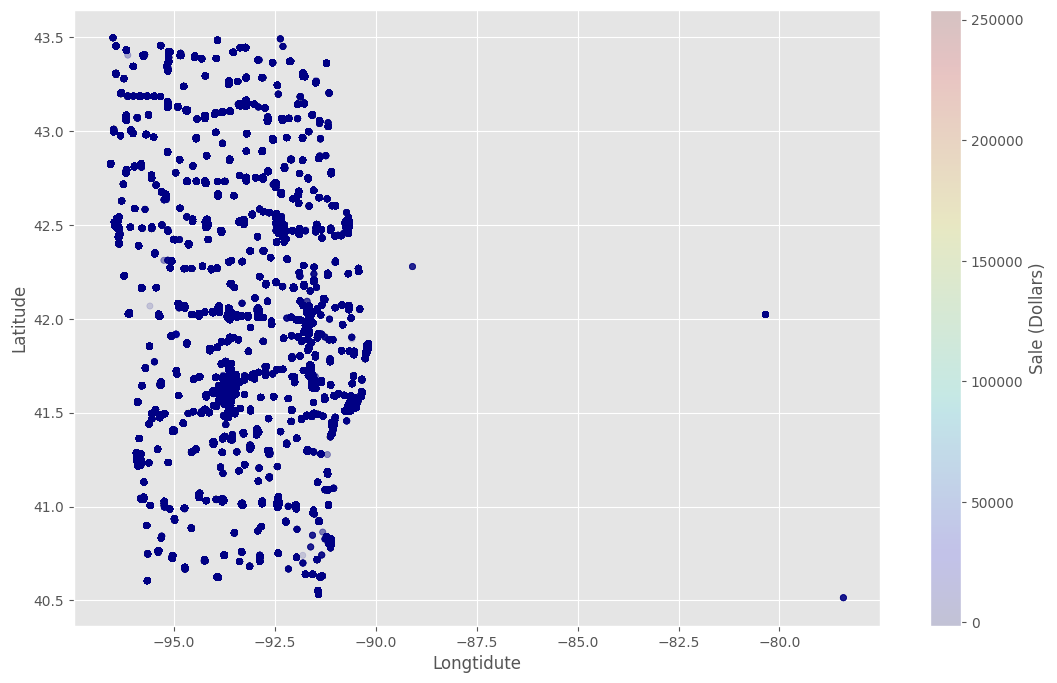

In [17]:
# Sampling for visualization
IowaSales_Main = IowaSales_Copy_Filled.drop(["Date", "Category Name"], axis=1)
IowaSales_Main.info(), IowaSales_Main.shape

m = 3000000
idx = np.random.permutation(IowaSales_Main.shape[0])[:m]
IowaSales_plot_sample = IowaSales_Main.loc[IowaSales_Main.index[idx], :]

# Fit the scale - to remove some outfiter
IowaSales_plot_sample = IowaSales_plot_sample[(((IowaSales_plot_sample["Latitude"] > 44.5) 
                                                |(IowaSales_plot_sample["Latitude"] < 40.5) 
                                                |(IowaSales_plot_sample["Longtidute"] > -75)) == False)]
plt.figure(figsize=(20,15))
IowaSales_plot_sample.plot(kind="scatter", x="Longtidute", y="Latitude", c="Sale (Dollars)", alpha=0.15, cmap=mpl.cm.get_cmap("jet"));


The code creates a scatter plot of the remaining data using longitude and latitude as the x and y coordinates and the "Sale (Dollars)" column as the colour to prepare a sample of the Iowa Sales dataset for visualisation by randomly selecting 3 million rows, filtering out any outliers based on latitude and longitude values, and then colouring the remaining data. The final image is 20 by 15 inches.

In [18]:
import array

def plot_digits(X, y, scalesize=10, figsize=(13, 10)):    
    plt.figure(figsize=figsize)
    interval = 100 / scalesize
    cmap = mpl.cm.get_cmap("jet")
    
    buckets = array.array('f')
    y_max = max(y)
    buckets.append(y_max)    
    for i in range(1, scalesize):
        buckets.append(np.percentile(y, interval * (scalesize - i)))    
    buckets.append(min(y))
    
    startval = 0
    bl = len(buckets)
    cur = 0
    first = True
    
    idx = (y == y_max)[:, 0]
    plt.scatter(X[idx, 0], X[idx, 1], c=[cmap(0)], s=y[idx], alpha=0.15)
    b_cur = None
    for b in buckets:
        cur = cur + 1
        b_pre = b_cur
        b_cur = b        
        if first: 
            first = False
            continue        
        idx = (y < b_pre)[:, 0] * (y >= b_cur)[:, 0]
        plt.scatter(X[idx, 0], X[idx, 1], c=[cmap(cur / bl)], s=y[idx], alpha=0.15)
        
       
    plt.axis("off")
    return plt

The Python method "plot_digits" accepts a two-dimensional input data matrix "X," a vector "y" that specifies the size of each circle for each data point, and a scalesize parameter that determines how many groups will be formed in the plot. The function then generates a scatter plot of the data points, where the colour of the circles denotes the various size categories of the data points and the size of the circles denotes a third variable.
The 'plt.figure' function is used to produce a figure, followed by the'mpl.cm.get_cmap' function to specify a colour map and the 'array' module to set up a list of 'buckets'. Then, it loops over each bucket to plot the relevant data points on the scatter plot, drawing the greatest size circles in red for the data points with the highest "y" value. The bucket index determines the colour of the circles while the size of the circles is decided by the 'y' variable. The function then uses the 'plt.axis("off")' function to disable the axis and the 'plt' function to return the figure.

With two variables shown on the X and Y axes and the third variable represented by the size and colour of the circles, this function is useful for visualising relationships and patterns in data with three variables.

# Dimentionality Reduction
why do we have to perform Dimentionality reduction ?

The technique of dimension reduction is crucial to data analysis, machine learning, and visualisation. It facilitates feature extraction, interpretability, enhanced algorithm performance, noise reduction, visualization, noise reduction, and multicollinearity mitigation. You may speed up computation, gain a better understanding of data linkages, and boost the effectiveness of machine learning models by lowering the number of dimensions. To avoid losing important information, it is vital to strike a balance between information retention and removing noise and redundancies.

In [19]:
from sklearn.model_selection import train_test_split
IowaSales_Main_Bak = IowaSales_Main.copy()
y_Sale = IowaSales_Main[['Sale (Dollars)']].values
X_Sale = IowaSales_Main.drop(['Sale (Dollars)', 'City'], axis=1).values
X_Sale_train, X_Sale_test, y_Sale_train, y_Sale_test = train_test_split(X_Sale, y_Sale)

In [20]:
m = 60000
idx_sale = np.random.permutation(X_Sale_train.shape[0])[:m]
X_Sale_sampled = X_Sale_train[idx_sale]
y_Sale_sampled = y_Sale_train[idx_sale]


# T-SNE
The non-linear dimensionality reduction method known as t-SNE (t-Distributed Stochastic Neighbor Embedding) is used to visualise high-dimensional data. By simulating the probability distribution of each data point over pairs of data points in both high-dimensional and low-dimensional spaces, it minimises the difference between these distributions. t-SNE is particularly well suited for visualising clusters or groups in the data and can show complex data structures.

CPU times: total: 32min 39s
Wall time: 2min 49s


C:\Users\tirth\AppData\Local\Temp\ipykernel_8584\1413958979.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap("jet")
C:\Users\tirth\.conda\envs\test\lib\site-packages\matplotlib\collections.py:963: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


<module 'matplotlib.pyplot' from 'C:\\Users\\tirth\\.conda\\envs\\test\\lib\\site-packages\\matplotlib\\pyplot.py'>

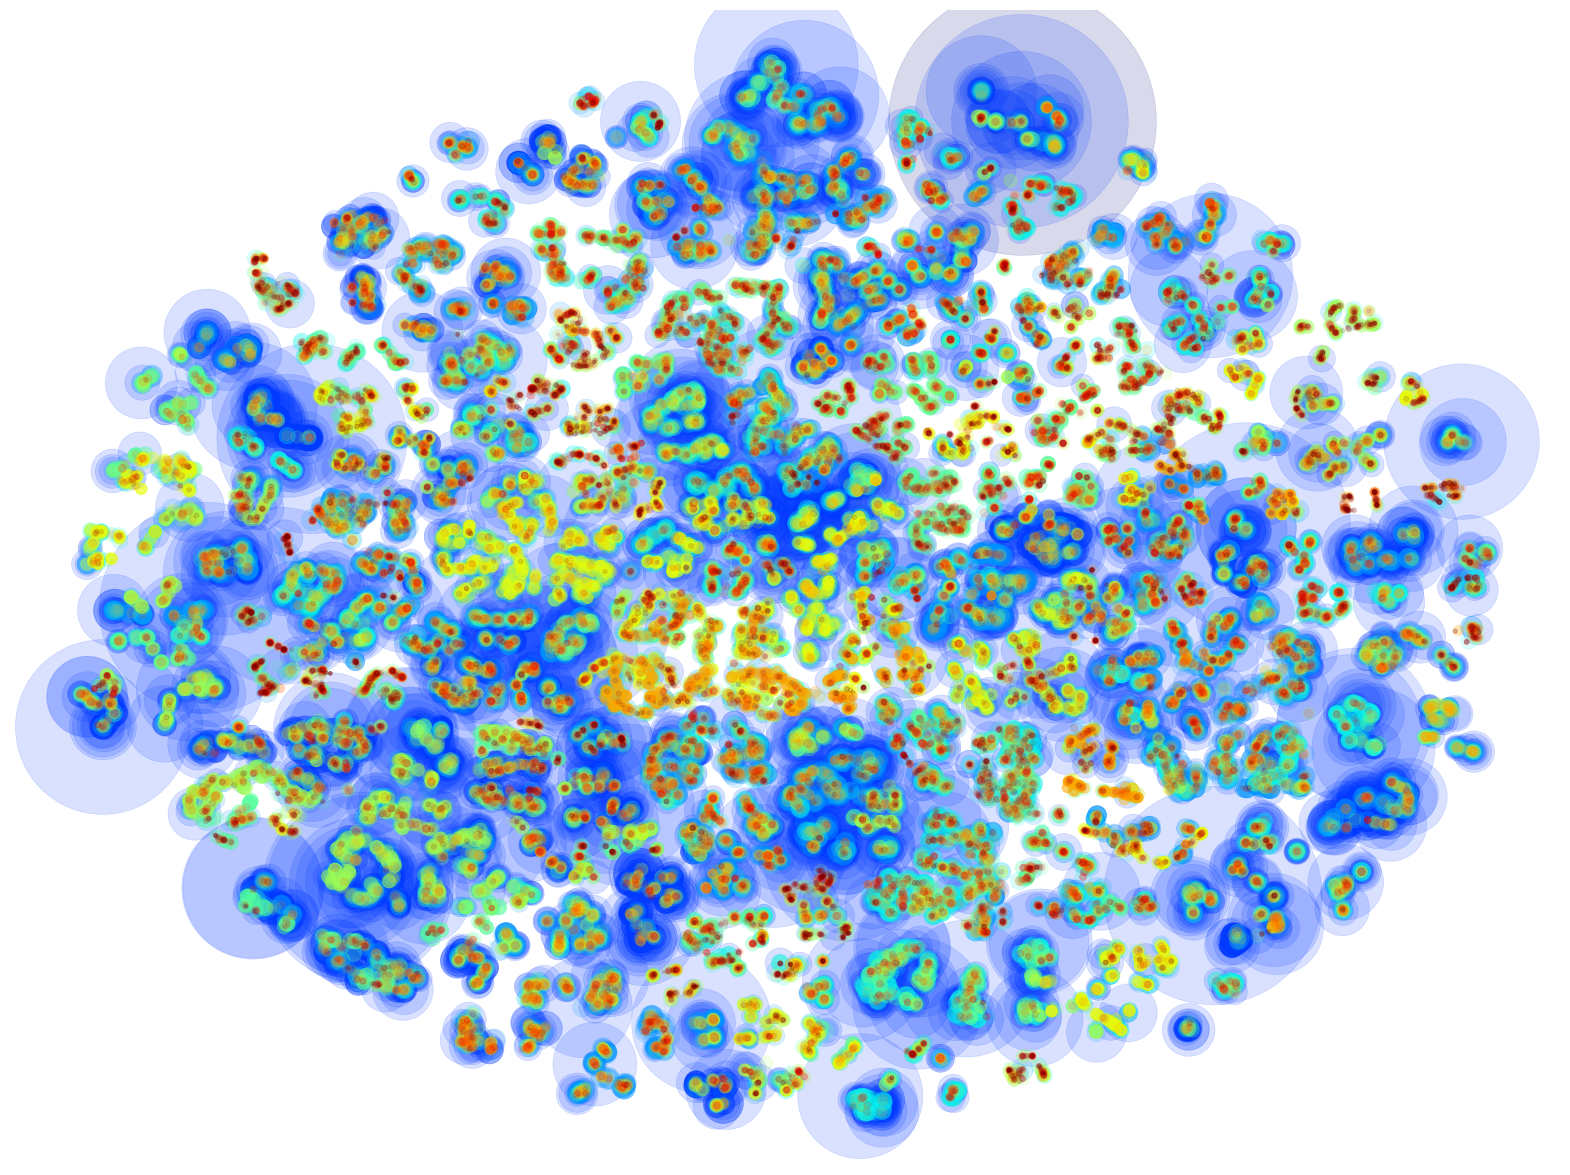

In [21]:

from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
%time X_sale_reduced_tsne = tsne.fit_transform(X_Sale_sampled)

plot_digits(X_sale_reduced_tsne, y_Sale_sampled, 10, figsize=(20,15))

# PCA 
PCA (Principal Component Analysis): PCA is a method for reducing the number of dimensions in a dataset by finding the principal directions (components) with the highest variance. In order to create a lower-dimensional representation that maintains the most information feasible, it projects the data onto these new directions. PCA is frequently employed in feature extraction, data compression, and exploratory data analysis.

CPU times: total: 0 ns
Wall time: 84 ms


C:\Users\tirth\AppData\Local\Temp\ipykernel_8584\1413958979.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap("jet")
C:\Users\tirth\.conda\envs\test\lib\site-packages\matplotlib\collections.py:963: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


<module 'matplotlib.pyplot' from 'C:\\Users\\tirth\\.conda\\envs\\test\\lib\\site-packages\\matplotlib\\pyplot.py'>

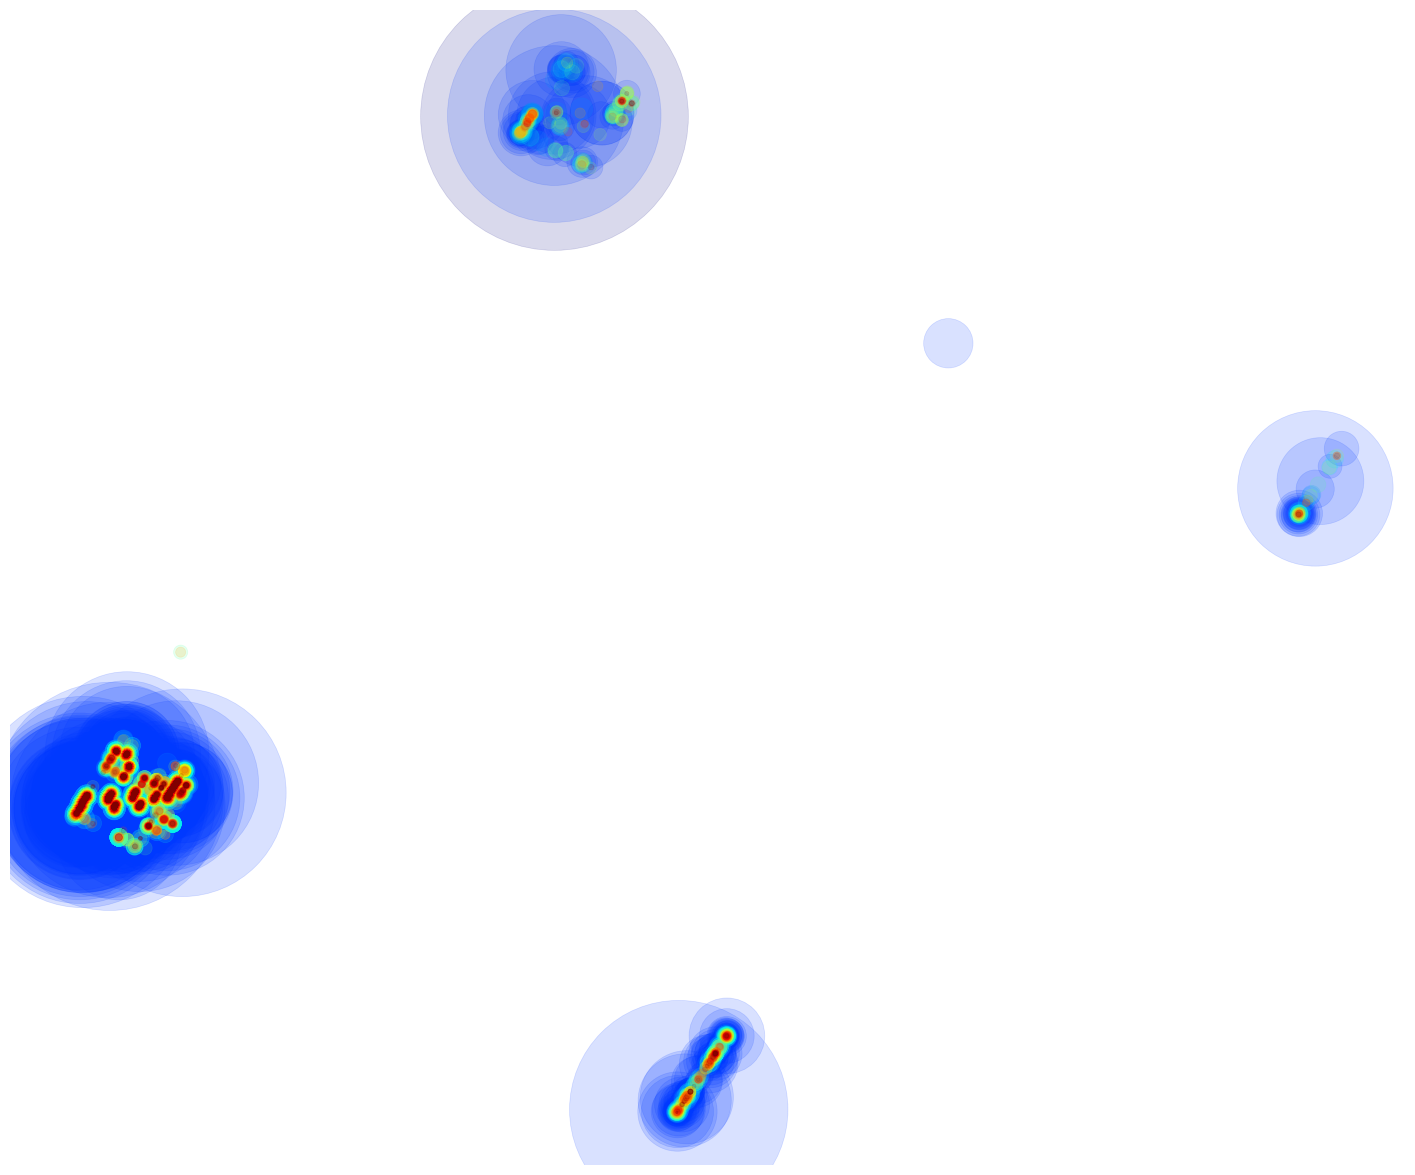

In [22]:
# PCA
from sklearn.decomposition import PCA

pca_2d = PCA(n_components=2, random_state=42)
%time X_sale_sampled_pca_2d = pca_2d.fit_transform(X_Sale_sampled)

plot_digits(X_sale_sampled_pca_2d, y_Sale_sampled, 10, figsize=(18,15))

* from PCA it looks there is some kind of data clustering there the fact that there are distinct clusters in the two-dimensional plot suggests that the original data had underlying structure that can be captured by PCA. The clustering suggests that there may be natural groupings or patterns in the data that can be further explored and potentially used to improve the accuracy of machine learning models.

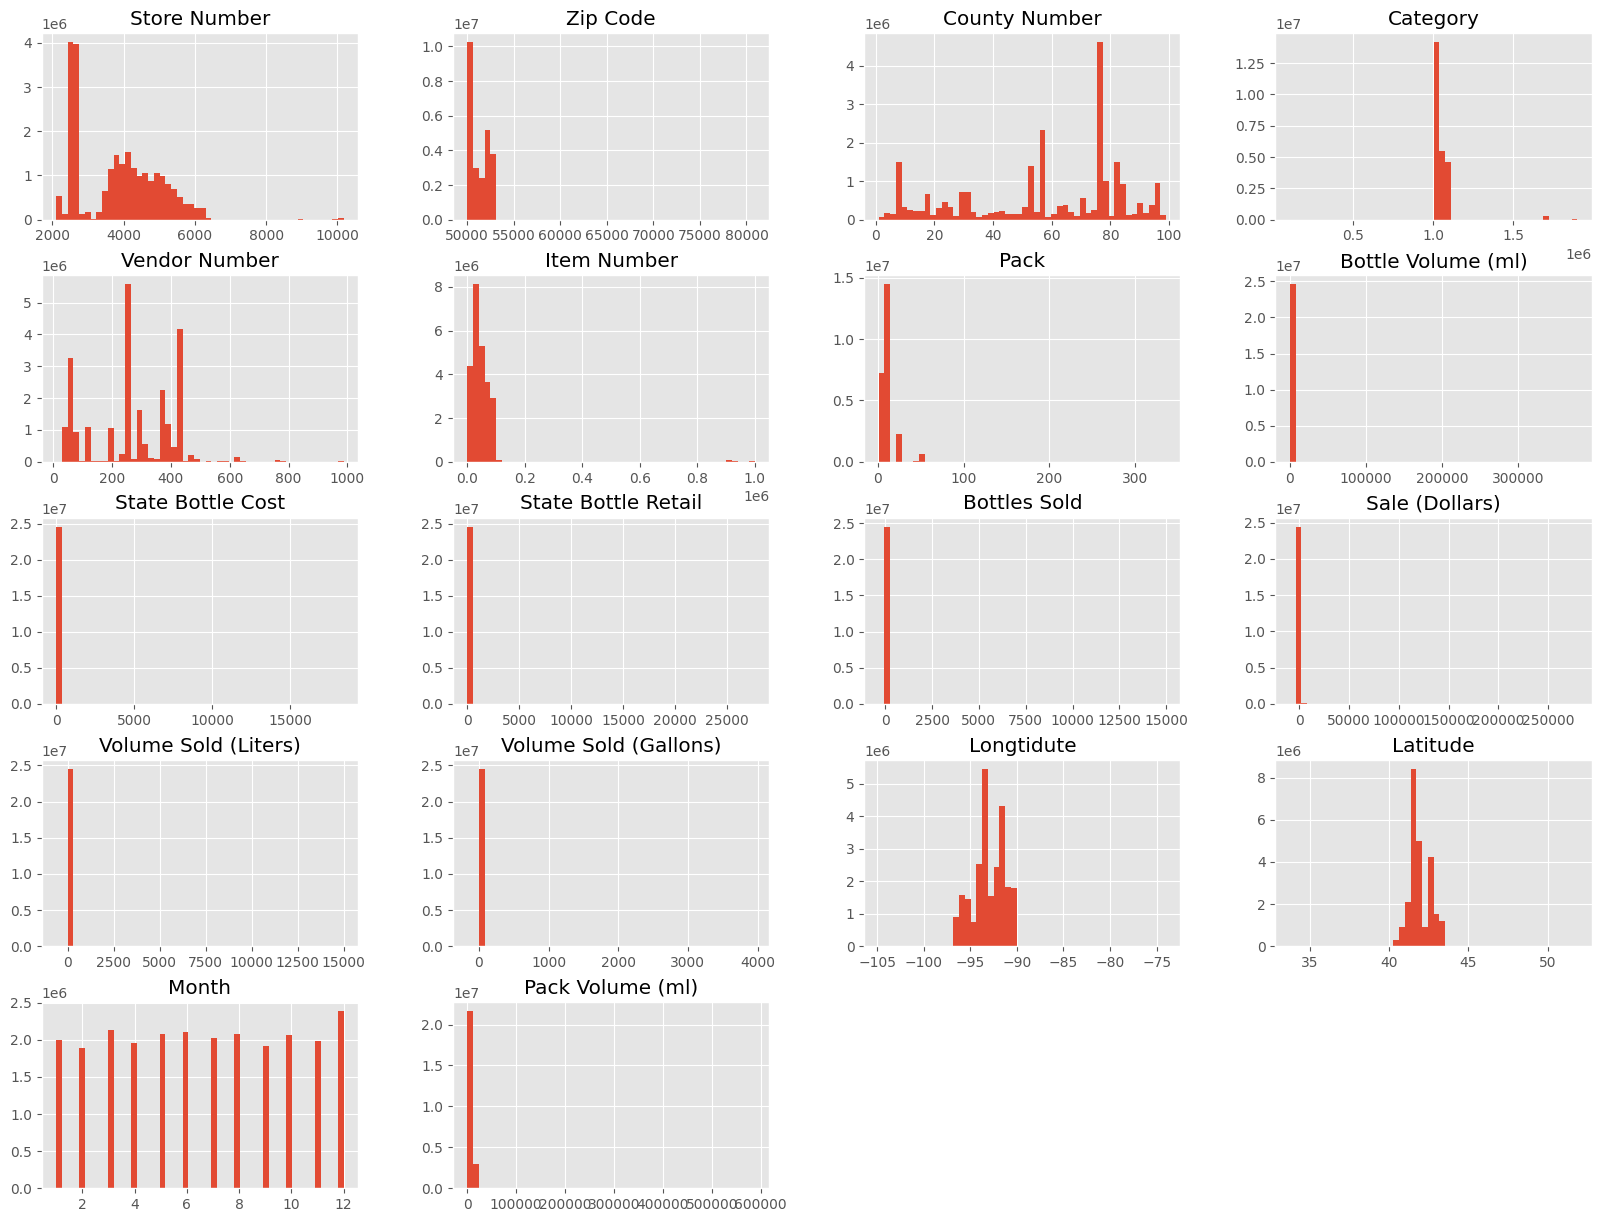

In [24]:
# %matplotlib inline
# import matplotlib.pyplot as plt
IowaSales_Main.hist(bins=50, figsize=(20,15))
plt.show()

* To use heap map to see  the correlation between features

In [26]:
# Save data for Model part
IowaSales_Copy_Filled.to_csv(".\IowaSalesCleaned.csv", index=False)